In [1]:
! pip install opencv-python==4.5.5.64

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 MB 9.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.7.0.72
    Uninstalling opencv-python-4.7.0.72:
      Successfully uninstalled opencv-python-4.7.0.72


In [1]:
import sys
from google.colab import drive
drive.mount('/content/drive')
sys.path.append(r"/content/drive/MyDrive/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys, os, json
import numpy as np
import pandas as pd
import seaborn as sns
import argparse, progressbar
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.axes import Axes
sns.set()


In [3]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from loader_util.preprocessing import ImageToArrayPreprocessor
from loader_util.preprocessing import AspectAwarePreprocessor
from loader_util.datasets import SimpleDatasetLoader
from loader_util.nn.conv import MinVGGNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from imutils import paths


In [4]:
# script constants
dataset_path = r"/content/drive/MyDrive/Colab Notebooks/ImageDataset/book2/flowers17/images"
n_epochs = 100
batch_size = 32

In [6]:
print(f"[INFO] loading images......")
image_paths = list(paths.list_images(dataset_path))
class_names = [pth.split(os.path.sep)[-2] for pth in image_paths]
print(len(class_names))
class_names = list(np.unique(class_names))
class_names

[INFO] loading images......
1360


['bluebell',
 'buttercup',
 'coltsfoot',
 'cowslip',
 'crocus',
 'daffodil',
 'daisy',
 'dandelion',
 'fritillary',
 'iris',
 'lilyvalley',
 'pansy',
 'snowdrop',
 'sunflower',
 'tigerlily',
 'tulip',
 'windflower']

In [7]:
# init the preprocessors, loaders and load the data
aap = AspectAwarePreprocessor(64, 64)
iap = ImageToArrayPreprocessor()
sdl = SimpleDatasetLoader(preprocessors=[aap, iap])
data, labels = sdl.load(image_paths, verbose=500)
data = data.astype("float") / 255.0

# now split the data
trainx, testx, trainy, testy = train_test_split(data, labels,
                                                test_size=0.25,
                                                random_state=42)

# encode the labels
lb = LabelBinarizer()
trainy = lb.fit_transform(trainy)
testy = lb.transform(testy)


[INFO] processed 500/1360
[INFO] processed 1000/1360


In [8]:
# construct the data augmentation generator
aug = ImageDataGenerator(rotation_range=30,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         fill_mode="nearest")


In [9]:
# init the optimizer model
print(f"[INFO] compiling model......")
opt = SGD(learning_rate=0.05)
model = MinVGGNet.build(width=64,
                        height=64,
                        depth=3,
                        classes=len(class_names))
model.compile(loss="categorical_crossentropy",
              optimizer=opt,
              metrics=["accuracy"])

[INFO] compiling model......


In [10]:
print(f"[INFO] training network......")
H = model.fit_generator(aug.flow(trainx, trainy, batch_size=batch_size),
                        validation_data=(testx, testy),
                        steps_per_epoch=len(trainx) // batch_size,
                        epochs=n_epochs,
                        verbose=1)

[INFO] training network......
Epoch 1/100


<ipython-input-10-11492991258a>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(aug.flow(trainx, trainy, batch_size=batch_size),


31/31 [==============================] - 14s 93ms/step - loss: 3.6093 - accuracy: 0.1761 - val_loss: 6.1545 - val_accuracy: 0.0824
Epoch 2/100
31/31 [==============================] - 2s 61ms/step - loss: 2.6335 - accuracy: 0.3036 - val_loss: 2.7053 - val_accuracy: 0.2265
Epoch 3/100
31/31 [==============================] - 2s 68ms/step - loss: 2.2826 - accuracy: 0.3462 - val_loss: 2.3753 - val_accuracy: 0.2912
Epoch 4/100
31/31 [==============================] - 2s 49ms/step - loss: 2.0271 - accuracy: 0.3927 - val_loss: 2.9338 - val_accuracy: 0.2412
Epoch 5/100
31/31 [==============================] - 1s 46ms/step - loss: 1.7429 - accuracy: 0.4656 - val_loss: 2.8605 - val_accuracy: 0.2029
Epoch 6/100
31/31 [==============================] - 1s 46ms/step - loss: 1.7317 - accuracy: 0.4676 - val_loss: 2.3247 - val_accuracy: 0.2882
Epoch 7/100
31/31 [==============================] - 2s 49ms/step - loss: 1.5721 - accuracy: 0.4929 - val_loss: 2.4646 - val_accuracy: 0.3147
Epoch 8/100
31/31

[INFO] evaluating network...
11/11 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

    bluebell       0.70      0.95      0.81        20
   buttercup       0.59      0.80      0.68        20
   coltsfoot       0.52      0.81      0.63        16
     cowslip       0.70      0.74      0.72        19
      crocus       0.39      0.47      0.42        15
    daffodil       0.56      0.45      0.50        20
       daisy       0.79      0.83      0.81        23
   dandelion       0.94      0.63      0.76        27
  fritillary       0.89      0.84      0.86        19
        iris       1.00      0.81      0.89        21
  lilyvalley       0.74      0.78      0.76        18
       pansy       0.92      0.75      0.83        16
    snowdrop       0.74      0.77      0.76        22
   sunflower       0.95      0.91      0.93        23
   tigerlily       0.88      0.83      0.86        18
       tulip       0.46      0.30      0.36        20

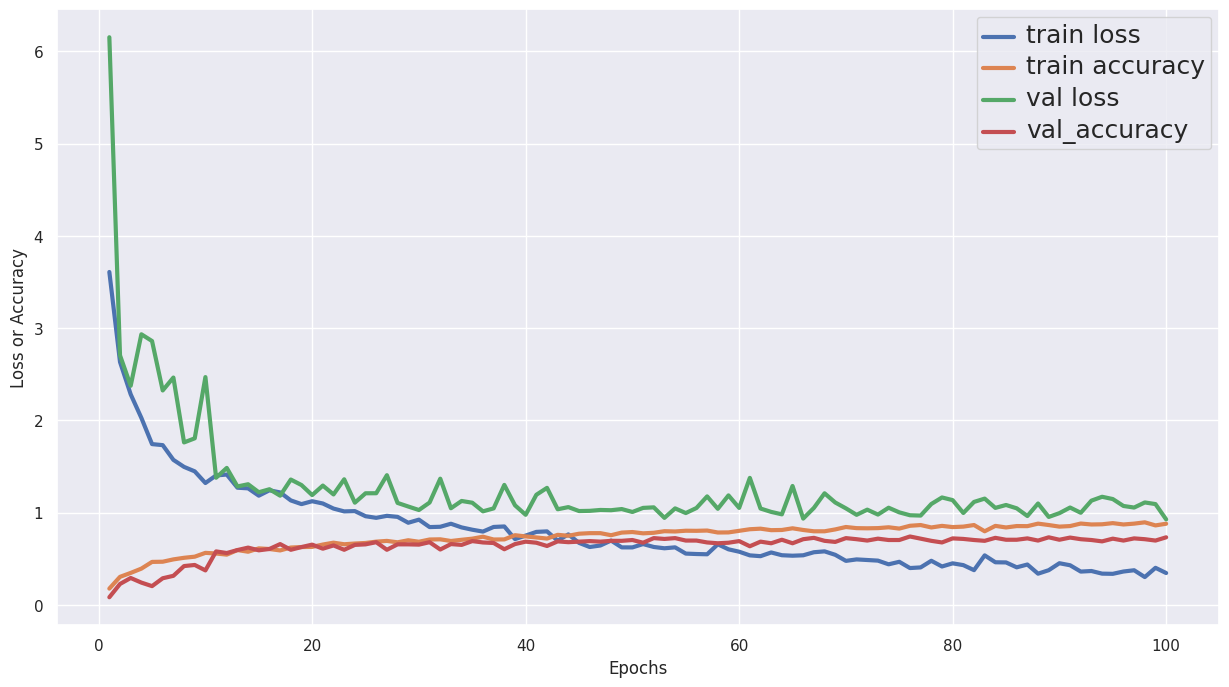

In [12]:
# evaluate the network
print ( "[INFO] evaluating network..." )
predictions = model.predict(testx, batch_size=32 )
print (classification_report(testy.argmax(axis=1 ),
predictions.argmax(axis=1 ), target_names=class_names))


# plot the performance
epochs = range(1,n_epochs+1)
loss = H.history['loss']
accuracy = H.history['accuracy']
val_loss = H.history['val_loss']
val_accuracy = H.history['val_accuracy']
plot_df = pd.DataFrame(data=np.c_[epochs,loss,accuracy,val_loss,val_accuracy],
                       columns=['epochs','loss', 'accuracy', 'val_loss', 'val_accuracy'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text